In [7]:
!pip install pandas numpy scikit-learn
!pip install pandas openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [10]:
# Загрузка данных из файла Excel
data = pd.read_excel("data.xlsx")

# Удаление нулевой строки (шапки)
data = data.iloc[1:]

# Определение признаков (все столбцы кроме 26 и 27)
features = data.columns[:-2]

# Выделение признаков и целевой переменной
X = data[features].values
y = data['ответ'].values

# Преобразование категориальной переменной "пол" в числовой формат
X[:, 1] = np.where(X[:, 1] == 'М', 0, 1)

# Создание объекта SimpleImputer для заполнения пропущенных значений средними значениями
imputer = SimpleImputer(strategy='mean')

# Заполнение пропущенных значений
X = imputer.fit_transform(X)

# Масштабирование признаков
scaler = StandardScaler()
X = scaler.fit_transform(X)

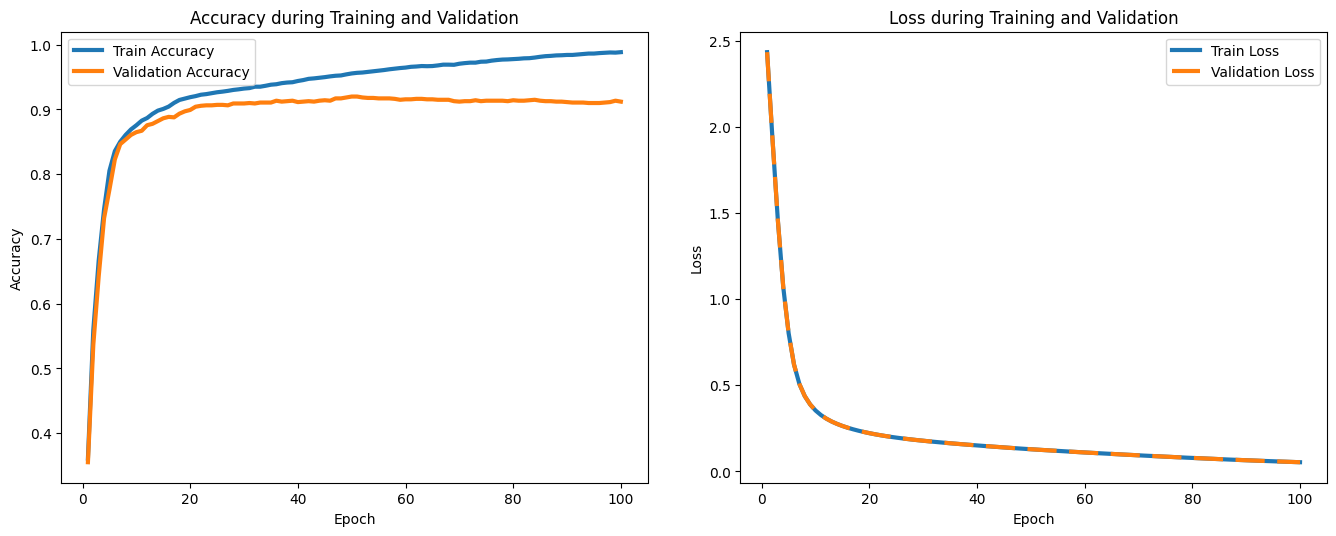

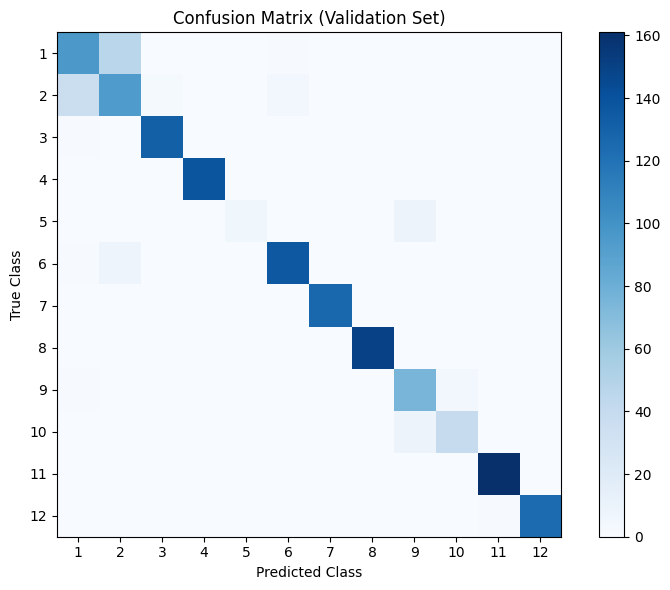

Accuracy on test set: 91.86%


In [11]:
# Разделение на обучающий, валидационный и тестовый наборы
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Создание модели нейронной сети с помощью MLPClassifier из scikit-learn
model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', random_state=42)

epochs = 100  # Количество эпох
train_accuracies = []
val_accuracies = []
losses = []
train_losses = []
val_losses = []
confusion_matrices = []

# Обучение модели на наборе данных
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    for epoch in range(epochs):
        model.partial_fit(X_train, y_train, classes=np.unique(y_train))
        
        # Оценка производительности модели на обучающем и валидационном наборах
        train_accuracy = model.score(X_train, y_train)
        val_accuracy = model.score(X_val, y_val)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Вычисление функции потерь
        loss = model.loss_
        losses.append(loss)
        train_losses.append(loss)
        val_loss = model.loss_curve_[-1]
        val_losses.append(val_loss)
        
        # Вычисление матрицы ошибок на валидационном наборе
        val_predictions = model.predict(X_val)
        confusion_matrix_val = confusion_matrix(y_val, val_predictions)
        confusion_matrices.append(confusion_matrix_val)

# График точности обучения и валидации на каждой эпохе
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', linewidth=3)
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training and Validation')
plt.legend()

# График функции потерь на каждой эпохе
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', linewidth=3)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', linestyle='--', dashes=(7, 3), linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training and Validation')
plt.legend()

plt.tight_layout(pad=3)
plt.show()

# График матрицы ошибок на последней эпохе
plt.figure(figsize=(8, 6))
labels = [1, 2, 3, 4,5,6,7,8,9,10,11,12]
plt.imshow(confusion_matrix_val, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Validation Set)')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Оценка производительности модели на тестовом наборе
test_accuracy = model.score(X_test, y_test)
print('Accuracy on test set: %.2f%%' % (test_accuracy * 100))


In [12]:
# Определение словаря с болезнями (12 значений)
diseases = {
    'соблюдение преддиабетовой диеты (при нормальном весе диета № 9, иначе диета № 8), повышение физической активности': 'риск диабета',
    'строгое соблюдение диабетовой диеты (при нормальном весе диета № 9, иначе диета № 8), ЛФК, физеотерапия, медикаментозное лечение': 'диабет',
    
    'соблюдение диеты при ишемической болезни (диета № 10), лечебные ванны (минеральные или лекарственные),лечебный душ (циркулярный или веерный), физеотерапия, галотерапия или ароматерапия, ЛФК': 'ишемическая болезнь сердца',
    'соблюдение диеты при пневмонии (диета № 13), ЛФК, массаж грудной клетки, гидротерапия, диадинамотерапия, амплипульстерапия, УВЧ-терапия, индуктотермия, ингаляционная терапия, нафталанотерапия': 'пневмония',
    
    'соблюдение диеты при оксалатах в почках (диета № 6), питьевой режим, соблюдать достаточную физическую нагрузку, контролировать содержание соли в пище (не рекомендуется выше 5 г.)': 'камни в почках оксалаты',
    'соблюдение диеты при фосфатах в почках (диета № 14), питьевой режим, лечебная физкультура': 'камни в почках фосфаты',
    'соблюдение диеты при уратах в почках (диета № 6 или диета № 14), медикаментозное лечение': 'камни в почках ураты',

    'соблюдение диеты при гипотериозе (допускается диета № 8), санаторно-курортное лечение, медикаментозная терапия в сочетании с радоновыми процедурами, азотные ванны (не содержащие радон)': 'гипотиреоз',

    'соблюдение диеты при почечной недостаточности (диета № 7), контроль потребляемой жидкости, при критическом состоянии требуется гемодиализ или перитонеальный диализ, ЛФК': 'почечная недостаточность',
    'соблюдение диеты при ревматоидном артрите (диета № 10Р), ЛФК, механотерапия, трудотерапия, тренировка баланса, ортезирование': 'ревматоидный артрит',
    
    'рекомендуем придерживаться здрового питания, исходя из отклонений в анализах': 'есть отклонения в анализах',
    'реабилитация не требуется': 'здоров'
}

#

# Ввод данных пользователя
user_data = input("Введите числа, разделенные пробелом: \n1. Возраст\n2. Пол (0 - мужской, 1 - женский)\n"+
                  "3. Значение глюкозы\n4. Значение гемоглобина\n5. Значение кетонных тел\n6. Значение ГФР\n"+
                  "7. Значение общего холестерина\n8. Значение LDL\n9. Значение HDL\n10. Значение лейкоцитов\n"+
                  "11. Значение лейкоцитной формулы\n12. Значение кислорода\n13. Значение оксалатов\n"+
                  "14. Значение фосфатов\n15. Значение уратов\n16. Значение мочевой кислоты\n"+
                  "17. Значение ТТГ\n18. Значение СТ4\n19. Значение СТ3\n20. Значение креатинина\n"+
                  "21. Значение мочевины\n22. Значение электролитов\n23. Значение белка\n24. Значение RF\n25. Значение anti CCR\n")
if not user_data:
    print("Ошибка: Вы не ввели значения")
else:
    numbers = user_data.split()
    try:
        # Преобразование данных пользователя
        user_data = np.array(numbers, dtype=np.float64)
        if len(user_data) != 25:
            print("Ошибка: Неверное количество чисел")
        else:
            user_data = user_data.reshape(1, -1)
            user_data[:, 1] = np.where(user_data[:, 1] == 0, 0, 1)
            user_data = imputer.transform(user_data)
            user_data = scaler.transform(user_data)

            # Предсказание класса
            prediction = model.predict(user_data)
            predicted_disease = diseases.get(prediction[0], 'Неизвестная болезнь')
            print('Предсказанная болезнь: %s' % predicted_disease)
            print('Предсказанная схема реабилитации: %s' % prediction[0])
    except ValueError:
        print("Ошибка: Вы ввели буквенные значения")


Введите числа, разделенные пробелом: 
1. Возраст
2. Пол (0 - мужской, 1 - женский)
3. Значение глюкозы
4. Значение гемоглобина
5. Значение кетонных тел
6. Значение ГФР
7. Значение общего холестерина
8. Значение LDL
9. Значение HDL
10. Значение лейкоцитов
11. Значение лейкоцитной формулы
12. Значение кислорода
13. Значение оксалатов
14. Значение фосфатов
15. Значение уратов
16. Значение мочевой кислоты
17. Значение ТТГ
18. Значение СТ4
19. Значение СТ3
20. Значение креатинина
21. Значение мочевины
22. Значение электролитов
23. Значение белка
24. Значение RF
25. Значение anti CCR
65 0 113 5.1 0.1 87 163 73 90 4 0.67 0.99 0.7 0.4 0.7 0 3.54 0.91 106 1.33 1.69 1 0.9 4 16
Предсказанная болезнь: риск диабета
Предсказанная схема реабилитации: соблюдение преддиабетовой диеты (при нормальном весе диета № 9, иначе диета № 8), повышение физической активности


В данном комментарии представлены несколько наборов вводимых числовых значений для удобства проверки:

65 0 113 5.1 0.1 87 163 73 90 4 0.67 0.99 0.7 0.4 0.7 0 3.54 0.91 106 1.33 1.69 1 0.9 4 16 - риск диабета

21 0 131 7 0.1 90 164 81 83 8 0.47 0.99 0.5 0.1 0.9 0.1 2.51 1.79 123 1.28 1.97 1 0.8 8 13 - диабет

37 1 72 3.7 0 100 149 81 68 10 0.38 0.95 0.9 0.6 0.3 0.4 0.33 0.39 52 0.95 0.96 1 0.8 3 6 - гипотиреоз

42 1 90 5.1 0 92 212 162 50 4 0.42 0.99 0 0.9 0.1 0.6 1.83 0.9 114 0.83 1.29 1 0 5 19 - ишемическая болезнь сердца

51 1 87 3.5 0 120 169 82 87 11 0.87 0.76 0.7 0.3 0.6 0.3 3.31 0.87 81 0.74 1.93 1 0.1 8 17 - пневмония

56 0 79 4.4 0 90 127 49 78 4 0.6 0.96 1.1 1 0.9 1 2.05 1.65 168 0.76 1.67 1 0.6 3 18 - камни в почках оксалаты

65 0 89 4.9 0 101 128 65 63 9 0.61 1 1.1 1.4 1.3 1.3 0.74 1.17 180 1.18 1.79 1 0.4 13 11 - камни в почках фосфаты

23 0 92 5.7 0 113 74 32 42 10 0.64 0.98 1 1.2 1.4 0.9 3.74 1.61 125 0.88 1.99 1 0.2 11 19 - камни в почках ураты

60 1 71 2.5 0 116 172 100 72 4 0.38 0.98 0.3 0.4 0.2 0.1 4.07 2.18 253 0.62 1.38 1 0.2 3 9 - гипотиреоз

43 1 83 3.4 0 81 93 40 53 9 0.53 0.96 0.4 0.6 0.1 0.9 1.58 0.9 128 1.7 9.91 1 2.4 4 2 - почечная недостаточность

56 0 95 3.5 0 106 65 21 44 10 0.73 0.98 0.8 0.3 0.1 0.3 3.21 1.58 160 1.18 1.5 1 1.9 14 28 - ревматоидный артрит

19 0 75 4.9 0 90 154 91 63 8 0.64 0.89 0.1 0.8 0.2 0.9 3.9 1.65 153 0.88 1.21 1 0.8 9 1 - есть отклонения

57 0 96 4.3 0 115 143 72 71 11 0.31 0.97 0.7 0.8 0.4 0.3 3.19 1.42 105 0.85 1.33 1 0.2 9 18 - здоров